In [1]:
import itk
from itk import RTK as rtk
import json
import os
import numpy as np
import matplotlib.pyplot as plt
plt.ion()
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact, IntSlider
%matplotlib widget


from dcc4cbct.fbcc import FBProblem, EpipolarPair
from dcc4cbct.misc import RecupParam
from dcc4cbct.rtk_utils import AddNoiseToProjections, ReadGeometryFile


# The simulated data

## The acquisition geometry
- source-to-isocenter = 570
- source-to-detector = 1000
- 180 equi-angular projections from 0 to 179.

In this geometry, with the RTK convention, the source at angle 0 is in `(0,0,sid)` and at angle 90 deg in `(sid,0,0)`.

## The detector
- Detector size = 1200 x 300
- Pixel size = 1 mm
- Half fan angle = 31 degrees approx.

## The sample
The sample is a (standard, i.e. low-contrast) Shepp-Logan phantom, of size 40mm

The sample is located at 2 different positions in the two halves of the trajectory:
- `(141,42,0,141,42)` for the first half-scan (from 0 deg to 89 deg included).
- `(141,42,0,-141,42)` for the second half-scan (90 deg to 179 deg included)


Note on the whole simulated data: thoe object is very small (compared to a human e.g.) and the detector is very large. This is necessary if the object is to be **viewed** by all projections. In other words, the object being closer to the source position, it gets kicked out of the field-of-view quickly. This can be visualized on the animation in the cell below.
Move the cursors `aa` and `bb` to move source position in each half-scan.

In [40]:
%%html
<iframe scrolling="no" title="geometrie" src="https://www.geogebra.org/material/iframe/id/sheystqe/width/1949/height/952/border/888888/sfsb/true/smb/false/stb/false/stbh/false/ai/false/asb/false/sri/false/rc/true/ld/true/sdz/true/ctl/false" width="1949px" height="952px" style="border:0px;"> </iframe>

In [2]:
import itk
from itk import RTK as rtk
import json
import os
import numpy as np
import matplotlib.pyplot as plt
plt.ion()
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact, IntSlider
%matplotlib widget


from dcc4cbct.fbcc import FBProblem, EpipolarPair
from dcc4cbct.misc import RecupParam
from dcc4cbct.rtk_utils import AddNoiseToProjections, ReadGeometryFile


interactive(children=(IntSlider(value=0, description='i', max=179), Output()), _dom_classes=('widget-interact'…

<function __main__.show_slice(i)>

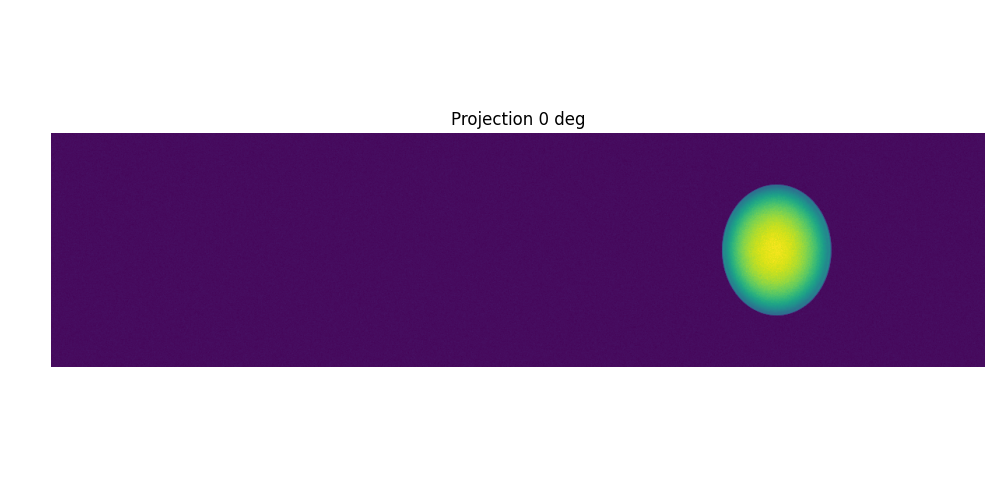

In [ ]:

stack = itk.imread("stack.mha")
geo = ReadGeometryFile("geo.xml")


fig,ax = plt.subplots(figsize=(10,5))
im = ax.imshow(stack[0])
fig.tight_layout()
ax.set_title(f"Projection 0 deg")
ax.set_axis_off()


def show_slice(i):
    slice = stack[i]
    vmin = slice.min()
    vmax = slice.max()
    im.set_data(slice)
    im.set_clim(vmin, vmax)
    ax.set_title(f"Projection {i} deg")
    fig.canvas.draw_idle()


interact(show_slice, i=IntSlider(min=0,max=stack.shape[0]-1, step=1, value=0))

1

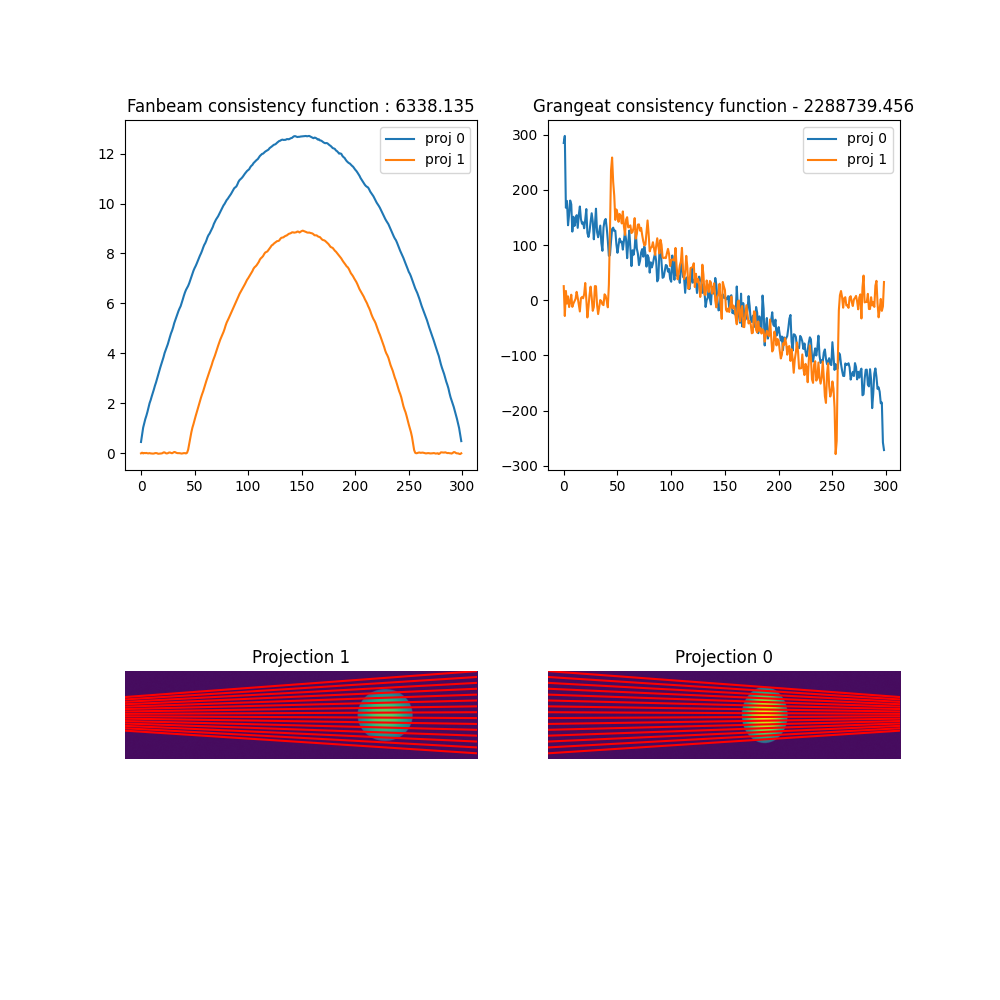

In [12]:
pb = FBProblem(geo, stack) 
pair = pb.create_pair([30, 100])
pair.analyze_pair(figsize=(10,10))


# Pair selection
In order to inform the selection of pairs, the consistency is computed for all pairs (i,j) where i in scan 1 (0-90 deg) and j in scan 2 (90-180 deg). The plots is shown below.
Depending on the epipolar geometry of each pair, some weird behavior may occur. Those pairs should be excluded. We mention there after two examples:

## Too large angular gaps
When both projection are almost opposite (e.g. (i,j)=(0,179)), the baseline intersects both detectors in their middle. The epipole could. lie inside the support of the projection. Since each projection pixel should be pre-weighted by the distance to the epipole, it could raise numerical issues. Those pairs are excluded.

To do so, we exclude all pairs such that the epipoles lies within the detector. It is easily seen that this happens iif the gap between both source positions is less than $(\pi - 2\times \text{half fan angle}) \approx 120 \text{deg}$.
See pair (0,189) above.

## Too small angular gaps
Another pathological case: the two source positions are very close from each other. This makes the abseline almost parallel to the detector planes, hence epipoles almost "at infinity": in other words, epipolar lines are almost parallel to the u-axis of the projections, in both projections. The DCC (beside numerical issues that may arise from the distance-to-epipole weighting) are then blind to horizontal motion of the sample. See pair (89,90) above. I excluded pairs whose angular gaps is less than 20 degrees.

In the figure below, the consistency maops are displayed. The two excluded regions are limited with red lines. One can see that the consistency is fairly homogeneous in the admissible region, while weird behaved in the 2 excluded regions.

In [38]:
import os
if os.path.isfile("cost_pre_corr.npz"):
    data = np.load("cost_pre_corr.npz")
    fb = data["fb"]
    gr = data["gr"]
else:
    fb = np.zeros((90,90),dtype=float)
    gr = np.zeros((90,90),dtype=float)
    def do_fb_work(i,j):
        print(i,j)
        pb = FBProblem(geo, stack)
        pair = pb.create_pair([i,j+90])
        fb[i,j] = pair.compute_fanbeam_consistency()
        gr[i,j] = pair.compute_grangeat_consistency()

    from concurrent.futures import ThreadPoolExecutor
    with ThreadPoolExecutor(max_workers=12) as executor:
        futures = []
        for i in range(90):
            for j in range(90):
                futures.append(executor.submit(do_fb_work, i, j))

        for future in futures:
            future.result()




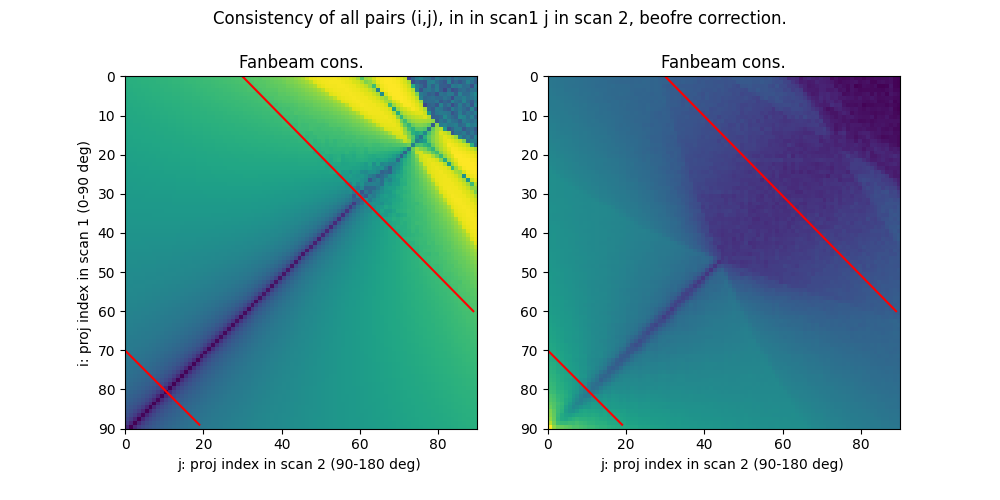

In [47]:
gridI, gridJ = np.meshgrid(np.arange(90),np.arange(90),indexing="ij")
mask1 = gridJ - gridI < 30
mask2 = gridI < gridJ + 70
fbmasked = (fb * mask1 * mask2).astype(float)
grmasked = (gr * mask1 * mask2).astype(float)

import matplotlib.colors as colors

fig, ax = plt.subplots(1,2,figsize=(10,5))
fig.suptitle("Consistency of all pairs (i,j), in in scan1 j in scan 2, beofre correction.")
ax[0].imshow(fb,norm=colors.LogNorm(),extent=(0,90,90,0))
ax[0].set_title("Fanbeam cons.")
ax[0].set_xlabel("j: proj index in scan 2 (90-180 deg) ")
ax[0].set_ylabel("i: proj index in scan 1 (0-90 deg)")
ax[0].plot((30,89),(0,60),'r')
ax[0].plot((0,19),(70,89),'r')
ax[1].imshow(gr, norm=colors.LogNorm(),extent=(0,90,90,0))
ax[1].plot((30,89),(0,60),'r')
ax[1].plot()
ax[1].set_title("Fanbeam cons.")
ax[1].set_xlabel("j: proj index in scan 2 (90-180 deg) ")
ax[1].plot((0,19),(70,89),'r')


# Selecting 2 pairs for minimization

I picked two pairs in the admissible regions (30,100) and (80,150).
The behavior of DCC cost functions is displayed in the following cell:

In [25]:
with open("sf_config.json","r") as f:
    config = json.load(f)

displacement_vector_x = config["phantom"]["translation_x_1"] - config["phantom"]["translation_x_2"]
displacement_vector_z = config["phantom"]["translation_z_1"] - config["phantom"]["translation_z_2"]
pairs_angles_1 = config["pairs"]["angle_1"]
pairs_angles_2 = config["pairs"]["angle_2"]


# Sc de ref (0,72) et (0,108). Toujours une vallee mais OK. Vallee 
pb = FBProblem(geo, stack)
pb.add_pair_to_problem([pairs_angles_1[0], pairs_angles_2[0]]) #0-72
pb.add_pair_to_problem([pairs_angles_1[1], pairs_angles_2[1]]) #0-108

if os.path.isfile("costs_2d.npz"):
    data = np.load("costs_2d.npz")
    cost_fb = data["fb"]
    cost_gr = data["gr"]
else:
    tx = np.linspace(displacement_vector_x - 10, displacement_vector_x + 10, 21)
    tz = np.linspace(displacement_vector_z - 10, displacement_vector_z + 10, 21)
    X,Z = np.meshgrid(tx, tz)
    cost_fb = np.zeros_like(X)
    cost_gr = np.zeros_like(X)

    from concurrent.futures import ThreadPoolExecutor, as_completed
    from tqdm import tqdm

    def compute_consistencies(i, j, x, z):
        fb = 0.
        gr = 0.
        for pair in pb.pairs:
            g0 = pair.g0
            g1 = pair.g1
            p0 = pair.p0
            p1 = pair.p1
            sid,sdd,ga,dx,dy,oa,ia,sx,sy = RecupParam(g1,0)
            rotmat = np.array(g1.GetRotationMatrix(0))
            delta_dx, delta_dy, delta_sid, _ = np.dot(rotmat, np.array([x, 0, z, 0]))
            g1bis = rtk.ThreeDCircularProjectionGeometry.New()
            new_sid = sid + delta_sid
            new_dx = dx + delta_dx
            new_dy = dy + delta_dy
            new_sx = sx + delta_dx
            new_sy = sy + delta_dy
            g1bis = rtk.ThreeDCircularProjectionGeometry.New()
            g1bis.AddProjectionInRadians(new_sid, sdd, ga, new_dx, new_dy, oa, ia, new_sx, new_sy)
            pair = EpipolarPair(g0, g1bis, p0, p1)
            fb += pair.compute_fanbeam_consistency()
            gr += pair.compute_grangeat_consistency()
        return (i, j, fb, gr)

    futures = []
    with ThreadPoolExecutor() as executor:
        for i, x in enumerate(tx):
            for j, z in enumerate(tz):
                futures.append(executor.submit(compute_consistencies, i, j, x, z))

        for f in tqdm(as_completed(futures), total=len(futures), desc="Processing pairs"):
            i, j, fb, gr = f.result()
            cost_fb[i, j] = fb
            cost_gr[i, j] = gr 




Attempt to set non-positive zlim on a log-scaled axis will be ignored.


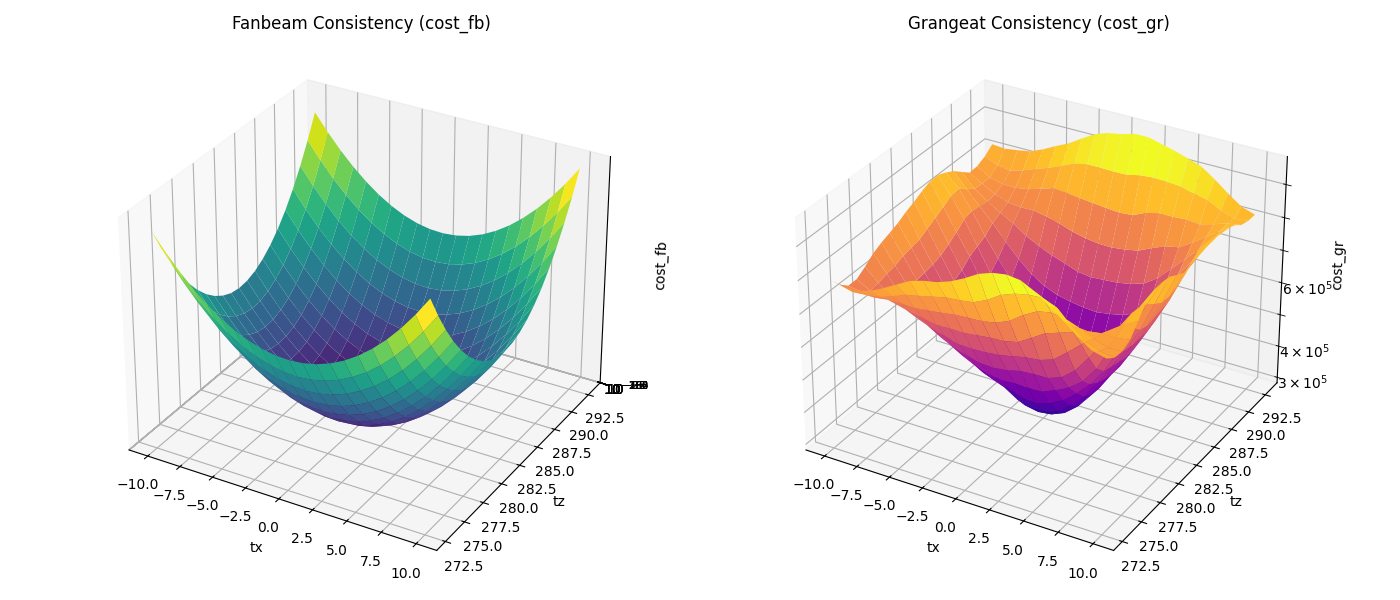

In [26]:
# Plotting the results
fig = plt.figure(figsize=(14, 6))

# Plot cost_fb
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(X, Z, cost_fb, cmap='viridis')
ax1.set_title('Fanbeam Consistency (cost_fb)')
ax1.set_xlabel('tx')
ax1.set_ylabel('tz')
ax1.set_zlabel('cost_fb')
ax1.set_zscale("log")

# Plot cost_gr
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(X, Z, cost_gr, cmap='plasma')
ax2.set_title('Grangeat Consistency (cost_gr)')
ax2.set_xlabel('tx')
ax2.set_ylabel('tz')
ax2.set_zlabel('cost_gr')
ax2.set_zscale("log")

plt.tight_layout()
plt.show()


In [27]:
# Minimizing the cost function

from scipy.optimize import minimize

ModuleNotFoundError: No module named 'scipy'

In [28]:
!pip install scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.8/20.8 MB 42.8 MB/s eta 0:00:00a 0:00:01
